In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools
import torch
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import imageio
import os

import utils.memory as mem   
from utils.feedforward import Feedforward
import utils.help_classes as hc
import utils.stats_functions as sf

## DQN Algorithm

### Q-Function

In [2]:
class QFunction(Feedforward):

    def __init__(self, state_dim, action_dim, hidden_sizes=[128,128], learning_rate = 0.0002):

        super().__init__(input_size=state_dim, hidden_sizes=hidden_sizes, output_size=action_dim)

        self.optimizer=torch.optim.Adam(self.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        self.loss = torch.nn.SmoothL1Loss() # MSELoss()

    def fit(self, states, actions, targets):

        self.train() # put model in training mode
        self.optimizer.zero_grad()

        # Forward pass
        acts = torch.from_numpy(actions)
        pred = self.Q_value(torch.from_numpy(states).float(), acts)

        # Compute Loss
        loss = self.loss(pred, torch.from_numpy(targets).float())
        
        # Backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def Q_value(self, states, actions):
        return self.forward(states).gather(1, actions[:,None])        
    
    def maxQ(self, states):
        return np.max(self.predict(states), axis=-1, keepdims=True)
        
    def greedyAction(self, states):
        return np.argmax(self.predict(states), axis=-1)
    
    def save(self, env_name, name):
            os.makedirs(f"{env_name}/weights", exist_ok=True)
            torch.save(self.state_dict(), f"{env_name}/weights/{name}.pth")
            print(f"Network saved at {env_name}/weights/{name}.pth")

    def load(self, env_name, name = "training_finished"):
            self.load_state_dict(torch.load(f"{env_name}/weights/{name}.pth"))
            print(f"Network loaded from {env_name}/weights/{name}.pth")

In [3]:
class DQNAgent(object):

    def __init__(self, state_space, action_space, **userconfig):
        
        if not isinstance(state_space, spaces.box.Box):
            raise hc.UnsupportedSpace('Observation space {} incompatible with {}. (Require: Box)'.format(state_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise hc.UnsupportedSpace('Action space {} incompatible with {}. (Reqire Discrete.)'.format(action_space, self))
        
        self._state_space = state_space
        self._action_space = action_space
        self._action_n = action_space.n

        self.train_iter = 0

        self._config = {
            "eps": 0.05,                       
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002,
            "update_target_every": 20,
            "use_target_net": True,
            "use_eps_decay": False,
            "eps_decay_mode": "exponential",
            "eps_min": 0.01,
            "eps_decay": 0.995
        }

        self._config.update(userconfig)
             
        self._eps = self._config['eps']
        
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])
                
        # Q Network
        self.Q = QFunction(state_dim=self._state_space.shape[0], 
                           action_dim=self._action_n,
                           learning_rate = self._config["learning_rate"])
        
        # Q Target
        self.Q_target = QFunction(state_dim=self._state_space.shape[0], 
                                  action_dim=self._action_n,
                                  learning_rate = 0)    # We do not want to train the Target Function, only copy the weights of the Q Network
        self._update_target_net()

    def _update_target_net(self):        
        self.Q_target.load_state_dict(self.Q.state_dict())
    
    def perform_greedy_action(self, state, eps = None):

        if eps is None:
            eps = self._eps

        if np.random.random() > eps:
            action = self.Q.greedyAction(state)
        else: 
            action = self._action_space.sample()        
        return action

    def _perform_epsilon_decay(self):

        if self._config["eps_decay_mode"] == "linear":
            self._eps = max(self._config['eps_min'], self._eps - self._config['eps_decay'])
        elif self._config["eps_decay_mode"] == "exponential":
            self._eps = max(self._config['eps_min'], self._eps * self._config['eps_decay'])
        else:
            raise ValueError("Error: Epsilon decay mode must be \"linear\" or \"exponential\".")

    def train(self, iter_fit=32):

        losses = []
        self.train_iter+=1
                     
        for i in range(iter_fit):

            # Sample from the replay buffer
            data = self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # Current state (s_t)
            a = np.stack(data[:,1]) # Action taken (a_t)
            rew = np.stack(data[:,2])[:,None] # Reward received (r)
            s_prime = np.stack(data[:,3]) # Next state (s_t+1)
            done = np.stack(data[:,4])[:,None] # Done flag (1 if terminal, else 0)

            
            if self._config["use_target_net"]:
                v_prime = self.Q_target.maxQ(s_prime)
            else:
                v_prime = self.Q.maxQ(s_prime)

            # target                                              
            td_target = rew + self._config['discount'] * (1.0 - done) * v_prime
            
            # optimize the lsq objective
            fit_loss = self.Q.fit(s, a, td_target)
            
            losses.append(fit_loss)

        if self._config["use_target_net"] and self.train_iter % self._config["update_target_every"] == 0:
            self._update_target_net()
                
        return losses

## Training the Agent

In [4]:
env_name = 'Pendulum-v1_weight_decay'
stats, losses = sf.load_stats(env_name)
env = gym.make("Pendulum-v1", render_mode="rgb_array")
if isinstance(env.action_space, spaces.Box):
    env = hc.DiscreteActionWrapper(env,5)

state_space = env.observation_space
action_space = env.action_space
agent = DQNAgent(state_space, action_space, use_eps_decay = True)
agent.Q.load(env_name)

Network loaded from Pendulum-v1_weight_decay/weights/training_finished.pth


/tmp/ipykernel_31198/2569811281.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(f"{env_name}/weights/{name}.pth"))


In [6]:
#env_name = 'CartPole-v1'
env_name = 'Pendulum-v1_weight_decay'
env = gym.make("Pendulum-v1", render_mode="rgb_array")
if isinstance(env.action_space, spaces.Box):
    env = hc.DiscreteActionWrapper(env,5)

# Initialize the agent with the correct state/action space
state_space = env.observation_space
action_space = env.action_space
agent = DQNAgent(state_space, action_space, use_eps_decay = True)

stats = []
losses = []

max_episodes = 200
max_steps = 1000
train_iterations = 32  # Number of training steps per episode

for episode in range(max_episodes):

    state = env.reset()
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility
    total_reward = 0
    
    for t in range(max_steps):
        done = False
        action = agent.perform_greedy_action(state)
        next_state, reward, done, truncated, _ = env.step(action)
        
        total_reward += reward

        agent.buffer.add_transition((state, action, reward, next_state, done))      # Store transition in the agent's memory and then train

        state = next_state

        if done: break
        
    losses.extend(agent.train(train_iterations))
    stats.append([episode, total_reward, t + 1])
    
    if agent._config["use_eps_decay"] and episode > int(0.5 * max_episodes):
        agent._perform_epsilon_decay()

    print(f"Episode {episode+1}/{max_episodes}, Total Reward: {total_reward}")
        
    if ((episode) % int(max_episodes/10) == 0) and episode > 0:
        agent.Q.save(env_name, name = f"episode_{episode}")

agent.Q.save(env_name, name = "training_finished")
sf.save_stats(env_name, stats, losses)


Episode 1/200, Total Reward: -8598.145407611126
Episode 2/200, Total Reward: -5138.084787278973
Episode 3/200, Total Reward: -7645.5076656457495
Episode 4/200, Total Reward: -9113.713616071038
Episode 5/200, Total Reward: -7666.165060528874
Episode 6/200, Total Reward: -7579.5840631712435
Episode 7/200, Total Reward: -8755.937286632143
Episode 8/200, Total Reward: -5267.954185468549
Episode 9/200, Total Reward: -8061.071436839826
Episode 10/200, Total Reward: -9334.073906643525
Episode 11/200, Total Reward: -8887.446512897968
Episode 12/200, Total Reward: -8103.323634492834
Episode 13/200, Total Reward: -8227.674892484505
Episode 14/200, Total Reward: -8604.995116206488
Episode 15/200, Total Reward: -8884.68082130847
Episode 16/200, Total Reward: -6894.964430928835
Episode 17/200, Total Reward: -6180.046882317451
Episode 18/200, Total Reward: -5009.559904888939
Episode 19/200, Total Reward: -5317.1296320262145
Episode 20/200, Total Reward: -6133.001235981699
Episode 21/200, Total Rewar

Plot saved at Pendulum-v1_weight_decay/stats/plots/Returns_plot.png


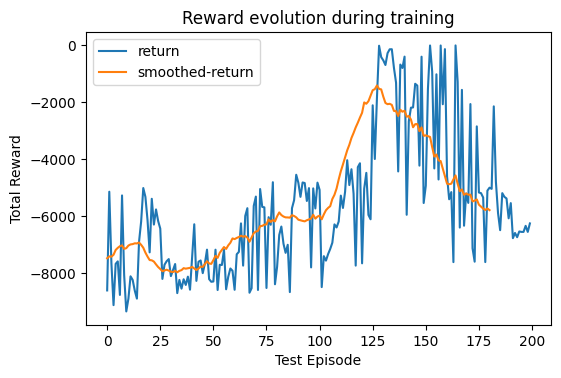

In [7]:
sf.plot_returns(stats, env_name)

Plot saved at Pendulum-v1_weight_decay/stats/plots/Losses_plot.png


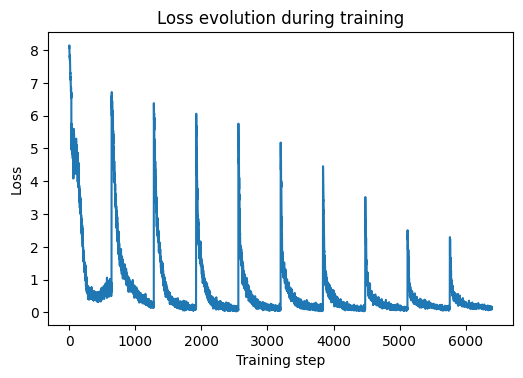

In [8]:
sf.plot_losses(losses, env_name)

## Testing the Agent

Test Episode 1, Total Reward: -5808.425967614645
Test Episode 2, Total Reward: -666.442573987776
Plot saved at Pendulum-v1_weight_decay/stats/plots/Test_results.png


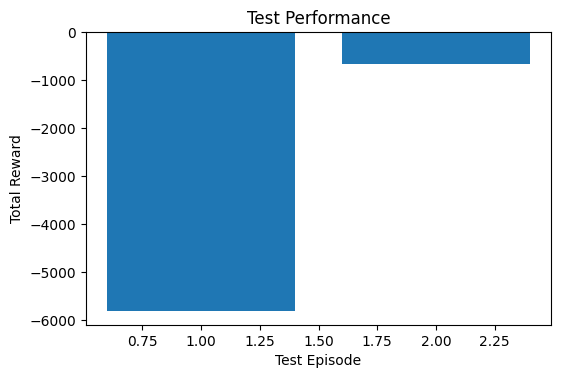

In [10]:
test_episodes = 2
test_rewards = []

max_steps = 1000

for episode in range(test_episodes):
    state = env.reset()
    state = state[0] if isinstance(state, tuple) else state
    done = False
    total_reward = 0
    frames = []
    
    for t in range(max_steps):
        frame = env.render()
        if frame is not None:
            frames.append(frame)
        action = agent.perform_greedy_action(state, eps=0.0)  # Fully greedy policy
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward

        if done: break
    
    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards)